# Transfer Learning

This notebook explores different efforts for transfer learning applied to MNIST and CIFAR with augmented images.

In [1]:
from IPython.display import display
from ipywidgets import FloatProgress

import sys
sys.path.append('../src')

import torch
import neuralnetworkclassifier as nnc
import dataset_manipulations as dm
import perturb as per
import numpy as np
import mlutils as ml
import pickle
import os

import matplotlib.pyplot as plt

In [168]:
Xtrain, Ttrain = dm.load_cifar_10('./cifar-10-batches-py/data_batch_*')
Xtest, Ttest = dm.load_cifar_10('./cifar-10-batches-py/test_batch')

In [169]:
noise_Xtrain = dm.apply_manipulations(Xtrain, per_func=lambda x: per.add_image_noise(x, variance=0.05))
noise_Xtest = dm.apply_manipulations(Xtest, per_func=lambda x: per.add_image_noise(x, variance=0.05))

In [170]:
morenoise_Xtrain = dm.apply_manipulations(Xtrain, per_func=lambda x: per.add_image_noise(x, variance=0.1))
morenoise_Xtest = dm.apply_manipulations(Xtest, per_func=lambda x: per.add_image_noise(x, variance=0.1)) 

In [171]:
lessnoise_Xtrain = dm.apply_manipulations(Xtrain, per_func=lambda x: per.add_image_noise(x, variance=0.025))
lessnoise_Xtest = dm.apply_manipulations(Xtest, per_func=lambda x: per.add_image_noise(x, variance=0.025)) 

In [172]:
import imp
imp.reload(nnc)
imp.reload(per)

<module 'perturb' from '../src/perturb.py'>

## Load before you Train

FYI, if this clean model has already been trained, you should just load it instead of training again!

In [201]:
if os.path.exists('./pretrained_cifar_clean.pkl'):
    with open('./pretrained_cifar_clean.pkl', 'rb') as f:
        nnet = torch.load(f)
        nnet.cuda()
else:
    nnet = per.train_cifar(Xtrain, Ttrain, verbose=True, random_seed=12)

In [202]:
nnet

NeuralNetwork_Convolutional(
                            n_channels_in_image=3,
                            image_size=32,
                            n_units_in_conv_layers=[64, 64, 128, 128, 256, 256, 512, 512],
                            kernels_size_and_stride=[(3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 1)],
                            max_pooling_kernels_and_stride=[(), (2, 2), (), (2, 2), (), (2, 2), (), (2, 2)],
                            n_units_in_fc_hidden_layers=[],
                            classes=[0 1 2 3 4 5 6 7 8 9],
                            use_gpu=True)
Sequential(
  (conv_0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output_0): ReLU()
  (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [203]:
if not os.path.exists('./pretrained_cifar_clean.pkl'):
    with open('./pretrained_cifar_clean.pkl', 'wb') as f:
        torch.save(nnet, f)

In [204]:
clean_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, Xtest, 100))
noise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, noise_Xtest, 100))
lessnoise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, lessnoise_Xtest, 100))
morenoise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, morenoise_Xtest, 100))
(clean_pct, lessnoise_pct, noise_pct, morenoise_pct)

(86.92, 83.65, 66.57, 28.79)

In [205]:
transfer_network = nnet.transfer_learn_setup([256, 512], overwrite_network=True, freeze=False)
transfer_network

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.2, inplace=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Dropout(p=0.2, inplace=False)
  (16): Conv2d(128, 256, kernel_size=(3, 3),

In [206]:
nnet.train(noise_Xtrain, Ttrain, n_epochs=5, batch_size=200,
           optim='Adam', learning_rate=0.0005, verbose=True)

Epoch 1 error 0.12701
Epoch 2 error 0.05766
Epoch 3 error 0.06599
Epoch 4 error 0.06534
Epoch 5 error 0.03360


In [207]:
clean_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, Xtest, 100))
noise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, noise_Xtest, 100))
lessnoise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, lessnoise_Xtest, 100))
morenoise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, morenoise_Xtest, 100))
(clean_pct, lessnoise_pct, noise_pct, morenoise_pct)

(82.62, 83.56, 83.73, 69.28999999999999)

In [26]:
clean_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, Xtest, 100))
noise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, noise_Xtest, 100))
lessnoise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, lessnoise_Xtest, 100))
morenoise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, morenoise_Xtest, 100))
(clean_pct, lessnoise_pct, noise_pct, morenoise_pct)

(84.15, 84.7, 82.25, 51.77)

## Plotting Transfer Learning Results

In [35]:
res_list = []
for ds, name in zip([lessnoise_Xtrain, noise_Xtrain, morenoise_Xtrain], ['0.025v', '0.05v', '0.1v']):
    with open('./pretrained_cifar_clean.pkl', 'rb') as f:
        nnet = torch.load(f)
    nnet.transfer_learn_setup([256, 512])
    nnet.train(ds, Ttrain, n_epochs=10, batch_size=200, optim='Adam', learning_rate=0.0005, verbose=True)
    
    res_list.append((name, per.run_increasing_noise(nnet, Xtest, Ttest, trials_per_step=1)))

Epoch 1 error 0.11042
Epoch 2 error 0.06881
Epoch 3 error 0.10979
Epoch 4 error 0.04882
Epoch 5 error 0.04916
Epoch 6 error 0.04672
Epoch 7 error 0.07684
Epoch 8 error 0.04518
Epoch 9 error 0.03732
Epoch 10 error 0.05553


FloatProgress(value=0.0, max=5.0)

Epoch 1 error 0.31086
Epoch 2 error 0.22993
Epoch 3 error 0.21027
Epoch 4 error 0.15766
Epoch 5 error 0.20218
Epoch 6 error 0.23977
Epoch 7 error 0.27837
Epoch 8 error 0.15961
Epoch 9 error 0.11501
Epoch 10 error 0.21371


FloatProgress(value=0.0, max=5.0)

Epoch 1 error 0.65080
Epoch 2 error 0.54928
Epoch 3 error 0.53250
Epoch 4 error 0.59626
Epoch 5 error 0.52486
Epoch 6 error 0.53409
Epoch 7 error 0.45697
Epoch 8 error 0.47659
Epoch 9 error 0.47861
Epoch 10 error 0.50568


FloatProgress(value=0.0, max=5.0)

In [36]:
res_list

[('0.025v',
  (array([0.001  , 0.01325, 0.0255 , 0.03775, 0.05   ]),
   array([87.09, 87.16, 86.48, 83.27, 76.58]),
   array([0., 0., 0., 0., 0.]))),
 ('0.05v',
  (array([0.001  , 0.01325, 0.0255 , 0.03775, 0.05   ]),
   array([81.31, 82.5 , 84.39, 84.97, 84.02]),
   array([0., 0., 0., 0., 0.]))),
 ('0.1v',
  (array([0.001  , 0.01325, 0.0255 , 0.03775, 0.05   ]),
   array([66.53, 67.93, 70.68, 73.76, 76.11]),
   array([0., 0., 0., 0., 0.])))]

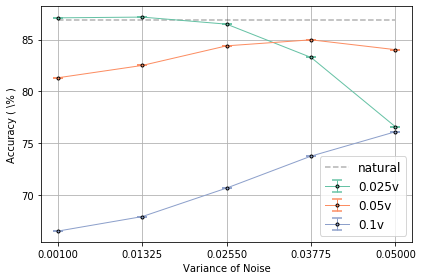

In [52]:
per.plot_increasing_noise(clean_pct, res_list, (0.001, 0.05), 5, 'delme.pdf')

FloatProgress(value=0.0, max=5.0)

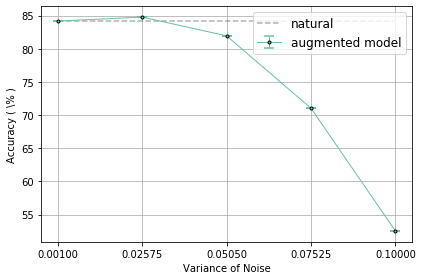

In [30]:
per.test_increasing_noise(nnet, Xtest, Ttest, var_range=(0.001, 0.1), trials_per_step=1)

## Transfer Learning on MNIST

In [3]:
Xtrain, Ttrain, Xtest, Ttest, _, _ = dm.load_mnist('./mnist.pkl.gz')

In [4]:
noise_Xtrain = dm.apply_manipulations(Xtrain, per_func=lambda x: per.add_image_noise(x, variance=0.05))
noise_Xtest = dm.apply_manipulations(Xtest, per_func=lambda x: per.add_image_noise(x, variance=0.05))

In [5]:
morenoise_Xtrain = dm.apply_manipulations(Xtrain, per_func=lambda x: per.add_image_noise(x, variance=0.1))
morenoise_Xtest = dm.apply_manipulations(Xtest, per_func=lambda x: per.add_image_noise(x, variance=0.1)) 

In [6]:
lessnoise_Xtrain = dm.apply_manipulations(Xtrain, per_func=lambda x: per.add_image_noise(x, variance=0.025))
lessnoise_Xtest = dm.apply_manipulations(Xtest, per_func=lambda x: per.add_image_noise(x, variance=0.025)) 

In [160]:
if os.path.exists('./pretrained_mnist_clean.pkl'):
    with open('./pretrained_mnist_clean.pkl', 'rb') as f:
        nnet = torch.load(f)
        nnet.cuda()
else:
    nnet = per.train_mnist(Xtrain, Ttrain, verbose=True)

In [161]:
nnet

NeuralNetwork_Convolutional(
                            n_channels_in_image=1,
                            image_size=28,
                            n_units_in_conv_layers=[10],
                            kernels_size_and_stride=[(7, 3)],
                            max_pooling_kernels_and_stride=[(2, 2)],
                            n_units_in_fc_hidden_layers=[],
                            classes=[0 1 2 3 4 5 6 7 8 9],
                            use_gpu=True)
Sequential(
  (conv_0): Conv2d(1, 10, kernel_size=(7, 7), stride=(3, 3))
  (norm_0): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output_0): ReLU()
  (pool_0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop_0): Dropout(p=0.2, inplace=False)
  (flatten): Flatten()
  (output_1): Linear(in_features=160, out_features=10, bias=True)
)
   Network was trained for 50 epochs with a batch size of 1500 and took 6.1463 seconds.
   Final objective value is 0.170

In [162]:
if not os.path.exists('./pretrained_mnist_clean.pkl'):
    with open('./pretrained_mnist_clean.pkl', 'wb') as f:
            torch.save(nnet, f)

In [163]:
clean_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, Xtest, 100))
noise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, noise_Xtest, 100))
lessnoise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, lessnoise_Xtest, 100))
morenoise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, morenoise_Xtest, 100))
(clean_pct, lessnoise_pct, noise_pct, morenoise_pct)

(97.42, 28.060000000000002, 18.09, 13.59)

In [164]:
nnet.transfer_learn_setup([256], freeze=False)

Sequential(
  (0): Conv2d(1, 10, kernel_size=(7, 7), stride=(3, 3))
  (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Dropout(p=0.2, inplace=False)
  (5): Flatten()
  (6): Linear(in_features=160, out_features=256, bias=True)
  (7): ReLU()
  (8): Linear(in_features=256, out_features=10, bias=True)
)

In [165]:
nnet.train(noise_Xtrain, Ttrain, n_epochs=20, batch_size=200,
           optim='Adam', learning_rate=0.0005, verbose=True)

Epoch 2 error 0.21997
Epoch 4 error 0.18007
Epoch 6 error 0.16218
Epoch 8 error 0.14380
Epoch 10 error 0.13490
Epoch 12 error 0.12675
Epoch 14 error 0.12679
Epoch 16 error 0.12592
Epoch 18 error 0.12104
Epoch 20 error 0.11978


In [166]:
clean_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, Xtest, 100))
noise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, noise_Xtest, 100))
lessnoise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, lessnoise_Xtest, 100))
morenoise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, morenoise_Xtest, 100))
(clean_pct, lessnoise_pct, noise_pct, morenoise_pct)

(95.67, 96.55, 96.17, 89.05999999999999)

In [167]:
clean_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, Xtest, 100))
noise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, noise_Xtest, 100))
lessnoise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, lessnoise_Xtest, 100))
morenoise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, morenoise_Xtest, 100))
(clean_pct, lessnoise_pct, noise_pct, morenoise_pct)

(95.67, 96.55, 96.17, 89.05999999999999)